### Week 3: Exploring Linguistic Isolation in LA County
This notebook explores linguistic isolation at the census tract level across LA county.
(Author: Aron Walker, with significant attribution to Yoh Kawano's instructions & models!)

#### Step 0: Setting up libraries and data

In [1]:
# Here are the libraries I will use:
import geopandas as gp
import numpy as np
import contextily as cx
import pandas as pd

For data, CalEnvironScreen has conveniently already attached my census variables of interest (total population and linguistic isolation) to census tract geometry.

In [2]:
# Here is the data I will use:
data_file = 'data/calenviroscreen40shpf2021shp.zip'
# Source: https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-40
data = gp.read_file(data_file)

#### Step 1: Exploring the structure of the census data

This section:

* counts the number of rows and columns
* identifies the types of data in each column
* looks at a few rows to get a sense of the inputs

In [3]:
# What are its dimensions?
data.shape

(8035, 67)

In [4]:
# What types of data are present?
data.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8035 entries, 0 to 8034
Data columns (total 67 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Tract       8035 non-null   float64 
 1   ZIP         8035 non-null   int64   
 2   County      8035 non-null   object  
 3   ApproxLoc   8035 non-null   object  
 4   TotPop19    8035 non-null   int64   
 5   CIscore     8035 non-null   float64 
 6   CIscoreP    8035 non-null   float64 
 7   Ozone       8035 non-null   float64 
 8   OzoneP      8035 non-null   float64 
 9   PM2_5       8035 non-null   float64 
 10  PM2_5_P     8035 non-null   float64 
 11  DieselPM    8035 non-null   float64 
 12  DieselPM_P  8035 non-null   float64 
 13  Pesticide   8035 non-null   float64 
 14  PesticideP  8035 non-null   float64 
 15  Tox_Rel     8035 non-null   float64 
 16  Tox_Rel_P   8035 non-null   float64 
 17  Traffic     8035 non-null   float64 
 18  TrafficP    8035 non-null   float64 
 19

CalEnviroScreen has also already adopted column names that make sense. My target variables are `TotPop19` and `Ling_Isol`.

In [5]:
# What do the first few rows look like?
data.head()

,Tract,ZIP,County,ApproxLoc,TotPop19,CIscore,CIscoreP,Ozone,OzoneP,PM2_5,...,Elderly65,Hispanic,White,AfricanAm,NativeAm,OtherMult,Shape_Leng,Shape_Area,AAPI,geometry
0,6.083002e+09,93454,Santa Barbara,Santa Maria,4495,36.019653,69.162885,0.034190,10.566273,7.567724,...,12.5028,68.9210,20.8899,0.4004,0.2670,1.3126,6999.357689,2.847611e+06,8.2091,"POLYGON ((-39795.070 -341919.191, -38126.384 -..."
1,6.083002e+09,93455,Santa Barbara,Santa Maria,13173,37.030667,70.637922,0.035217,11.561917,7.624775,...,5.3519,78.6229,13.2240,2.5051,0.0000,0.9489,19100.578232,1.635292e+07,4.6990,"POLYGON ((-39795.070 -341919.191, -39803.632 -..."
2,6.083002e+09,93454,Santa Barbara,Santa Maria,2398,31.213140,61.069087,0.034190,10.566273,7.548835,...,12.8857,65.7214,30.6088,0.9591,0.0000,2.1685,4970.985897,1.352329e+06,0.5421,"POLYGON ((-38115.747 -341130.248, -38126.384 -..."
3,6.083002e+09,93455,Santa Barbara,Orcutt,4496,6.639331,5.988401,0.036244,13.615432,7.660570,...,14.4128,22.9537,69.1948,0.9342,0.7117,2.5356,6558.956012,2.417717e+06,3.6699,"POLYGON ((-37341.662 -348530.437, -37252.307 -..."
4,6.083002e+09,93455,Santa Barbara,Orcutt,4008,14.022852,23.121533,0.036244,13.615432,7.663210,...,18.8872,33.4082,59.7804,0.6986,1.4721,1.3723,6570.368730,2.608422e+06,3.2685,"POLYGON ((-39465.107 -348499.262, -38244.305 -..."


In [6]:
# What do the last few rows look like?
data.tail()

,Tract,ZIP,County,ApproxLoc,TotPop19,CIscore,CIscoreP,Ozone,OzoneP,PM2_5,...,Elderly65,Hispanic,White,AfricanAm,NativeAm,OtherMult,Shape_Leng,Shape_Area,AAPI,geometry
8030,6.037430e+09,91016,Los Angeles,Monrovia,5339,17.124832,30.610187,0.062365,88.699440,11.873339,...,17.4752,28.7132,53.3995,1.5733,0.0000,7.1549,7166.130635,1.938016e+06,9.1590,"POLYGON ((185152.883 -426843.064, 185240.372 -..."
8031,6.037431e+09,91007,Los Angeles,Arcadia,4365,13.841990,22.566818,0.059387,79.987554,11.816074,...,10.4926,10.9507,26.3918,3.3677,0.0000,3.3677,3941.781806,4.855630e+05,55.9221,"POLYGON ((179874.001 -429709.190, 179885.911 -..."
8032,6.037431e+09,91016,Los Angeles,Monrovia,6758,39.697849,74.508321,0.061338,84.579963,11.892654,...,7.2951,58.2273,16.1438,8.9967,0.0000,1.1098,8020.091253,3.015661e+06,15.5223,"POLYGON ((184530.475 -428031.241, 184535.255 -..."
8033,6.037534e+09,90201,Los Angeles,Bell,6986,62.931044,97.049924,0.046325,46.994400,12.019728,...,9.4188,91.4114,6.9425,0.6728,0.2577,0.7157,4949.116808,8.118955e+05,0.0000,"POLYGON ((167498.880 -447404.351, 167453.159 -..."
8034,6.037534e+09,90201,Los Angeles,Bell Gardens,2358,63.315048,97.226425,0.047165,50.541381,12.025885,...,10.0933,91.0941,1.3147,1.9084,0.0000,0.0000,4420.126752,5.098718e+05,5.6828,"POLYGON ((169695.249 -447290.043, 169560.378 -..."


In [7]:
# What does a random row look like?
data.sample()

,Tract,ZIP,County,ApproxLoc,TotPop19,CIscore,CIscoreP,Ozone,OzoneP,PM2_5,...,Elderly65,Hispanic,White,AfricanAm,NativeAm,OtherMult,Shape_Leng,Shape_Area,AAPI,geometry
3284,6.055202e+09,94558,Napa,Unincorporated Napa County area,1737,15.070853,25.731215,0.043195,29.993777,6.708099,...,20.0345,17.4439,78.0656,2.7058,1.1514,0.1727,145385.307054,7.590305e+08,0.4606,"POLYGON ((-203928.909 93670.474, -203763.874 9..."


#### Step 2: Limiting the data to what interests me

First, I am only looking at LA County:

In [8]:
# Filter by `County` for Los Angeles
data_la = data[data['County']=='Los Angeles']

# Did it work?
np.unique(data_la['County'])

array(['Los Angeles'], dtype=object)

Next, for each census tract, I really only want:

* tract geometry
* total population
* linguistic isolation score

In [9]:
# Here are the columns I want as labeled in the data:
columns_of_interest = ['geometry',
                       'TotPop19',
                       'Ling_Isol']

# Here is the data with just those columns:
data2 = data_la[columns_of_interest]

# Did it work?
data2.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2343 entries, 5692 to 8034
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   2343 non-null   geometry
 1   TotPop19   2343 non-null   int64   
 2   Ling_Isol  2343 non-null   float64 
dtypes: float64(1), geometry(1), int64(1)
memory usage: 73.2 KB


Finally, I only want census tracts with people.

In [10]:
# Drop the rows (tracts) without people
data2 = data2[data2['TotPop19']>0]

In [11]:
# What are the dimensions now?
data2.shape

(2327, 3)

#### Step 3: Inspect the data with distributions and maps

Since I only have two variables, a scatterplot is a quick way to check it out:

<AxesSubplot: xlabel='TotPop19', ylabel='Ling_Isol'>

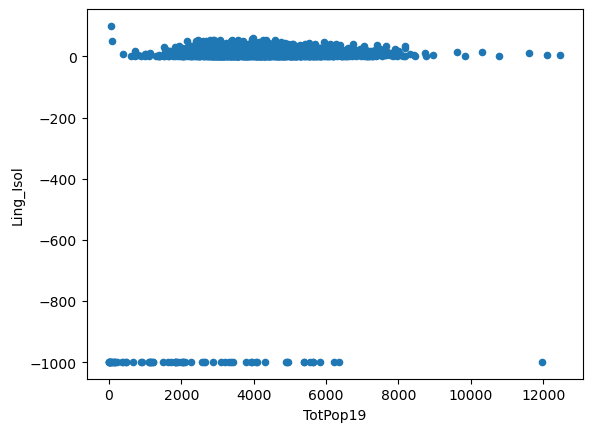

In [12]:
data2.plot(kind = 'scatter', x = 'TotPop19', y = 'Ling_Isol')

Yikes!

According to the CalEnviroScreen data dictionary:
*In addition, census tracts with highly unreliable estimates for the educational attainment, linguistic isolation, poverty, unemployment, and housing burden indicators were assigned “NA.”*

In [13]:
# How many rows are "NA" for linguistic isolation?
sum(data2['Ling_Isol'].isna())

0

Based on this finding and the scatterplot, it looks like "NA" got replaced with -999?

In [14]:
# How many rows have linguistic isolation -999?
sum(data2['Ling_Isol']==-999)

70

Yep. Okay, let's drop "highly unreliable" data...

<AxesSubplot: xlabel='TotPop19', ylabel='Ling_Isol'>

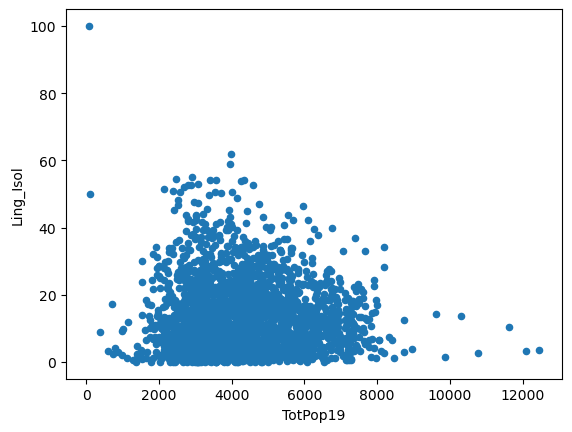

In [15]:
# Drop tracts with -999 values for linguistic isolation
data3 = data2[data2['Ling_Isol']>-900]

# Did it work?
data3.plot(kind = 'scatter', x = 'TotPop19', y = 'Ling_Isol')

Okay, that seems reasonable. Let's look at each variable's distribution seperately:

<AxesSubplot: >

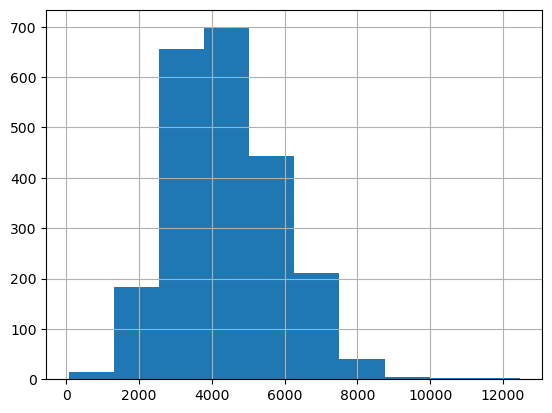

In [16]:
# Tract population histogram
data3['TotPop19'].hist()

<AxesSubplot: >

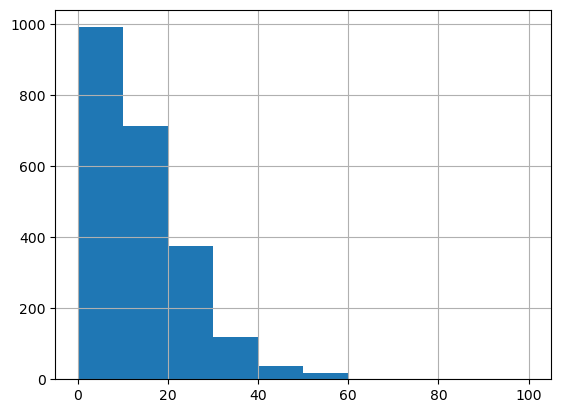

In [17]:
# Tract linguistic isolation histogram
data3['Ling_Isol'].hist()

Both look reasonable. Just for my learning... can I log transform the linguistic isolation data?

<AxesSubplot: >

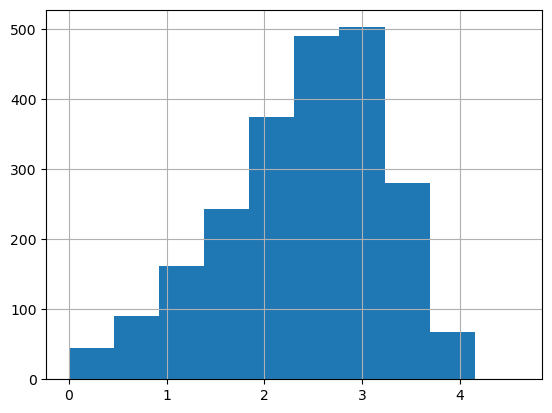

In [18]:
# Tract population histogram
log_li = np.log(data3['Ling_Isol']+1)
log_li.hist()

Now let's make sure the data map...

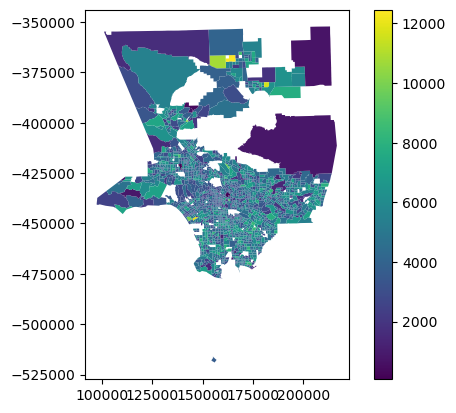

In [19]:
# Plot population
plot = data3.plot(column='TotPop19',
           legend=True)

<AxesSubplot: >

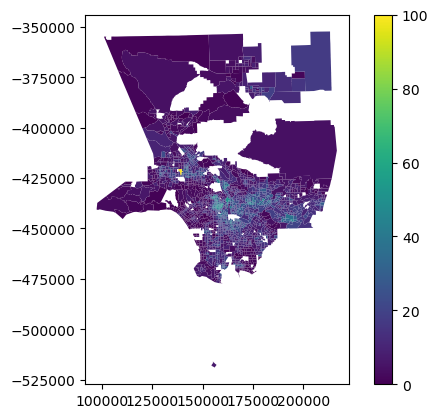

In [20]:
# Plot linguistic isolation
data3.plot(column='Ling_Isol',
           legend=True)

The data plot. Those big holes must be the census tracts dropped for either lacking population or for having "highly unreliable" linguistic isolation scores. I guess I could check that by plotting before those rows were removed...

<AxesSubplot: >

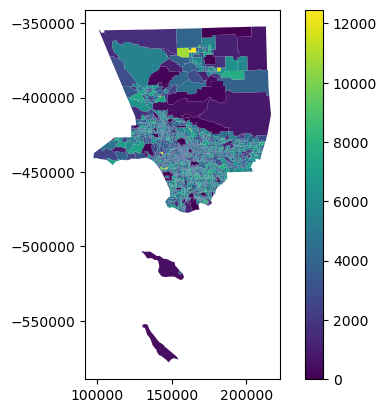

In [21]:
# Plot population
data_la.plot(column='TotPop19',
           legend=True)

<AxesSubplot: >

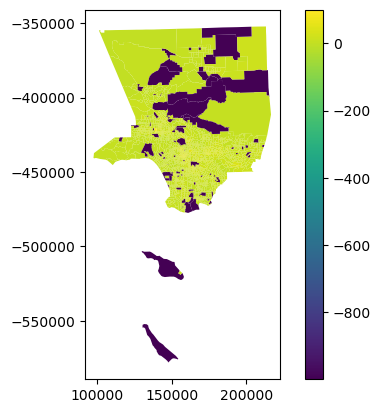

In [22]:
# Plot linguistic isolation
data_la.plot(column='Ling_Isol',
           legend=True)

There are the tracts with errors, matching the "holes" in the earlier maps. Many of these seem reasonable -- the islands, low population tracts in the mountains, the port of LA, the airport (and/or the big refinery nearby).

But looking at the first scatter plot, some had non-trivial populations. Let's looks at those again...

<AxesSubplot: >

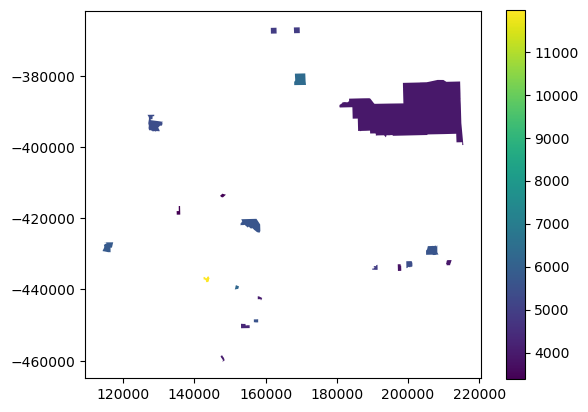

In [23]:
# First, let's make a population cutoff based on the population distribution
tract_pop_sd = np.std(data_la['TotPop19'])
tract_pop_mean = np.mean(data_la['TotPop19'])
cutoff = tract_pop_mean -2*tract_pop_sd

# Next, let's filter the data to negative `Ling_Isol` values with at least -2 SD pop:
tracts_to_examine = data_la[(data_la['TotPop19']>=cutoff) & (data_la['Ling_Isol']< 0)]

# And let's plot the top 20
odd_sorted=tracts_to_examine.sort_values(by='TotPop19',ascending = False)
odd_sorted.head(20).plot(column='TotPop19',
           legend=True)

I'm lost! I need a basemap!

In [24]:
# Source for the following process: https://geopandas.org/en/stable/gallery/plotting_basemap_background.html
# Check coordiante system
odd_sorted.crs

<Derived Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

That's not what I need, so let's change it and then plot it

In [25]:
# Change coordinate system
mappable = odd_sorted.to_crs(epsg=3857)

# Let's check!
mappable.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

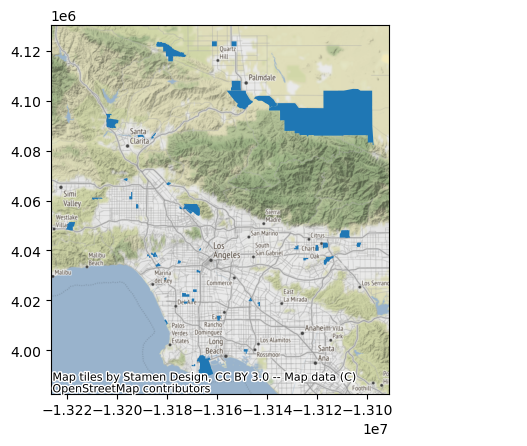

In [26]:
# Plot it!
plot = mappable.plot()
cx.add_basemap(plot)

How about just the five most populated?

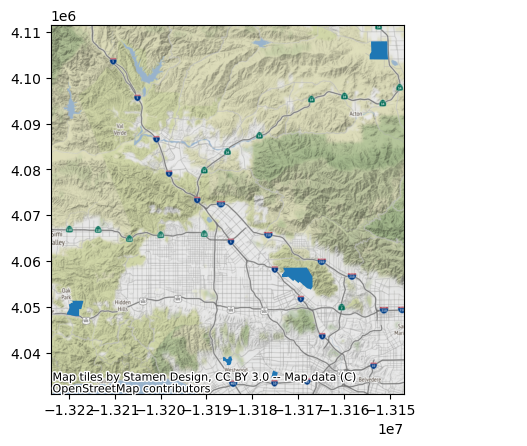

In [27]:
plot_top_five = mappable.head().plot()
cx.add_basemap(plot_top_five)

Curious. I think the next step would be to explore each of these places. I think that's beyond the scope for today.

Before finishing, I should make sure I actually do something with census data from social explorer...

In [28]:
# Load census data
census = pd.read_csv('data/R13285182_SL140.csv',
                     dtype={'Geo_FIPS':str})


Linguistic isolation appears to not be one of the obvious choices on social explorer. How about... fraction of households with a phone?

In [29]:
# Name the two relevant columns with something understandable
census = census.rename(columns = {'SE_A10029_001':'households','SE_A10029_006':'no_phone'})

# Add a column that is the fraction of homes without a phone
census['f_no_phone']=census['no_phone']/census['households']

I want to merge these data with my mappable data. I imported the census data to the FIPS codes as strings, but the CalEnviroScreen is a float. Let's make the CalEnviroScreen data into a string. Also, let's add a leading zero, and give it the same column name as the census.

Also, I'm just going to use the subset of tracts that have issues with linguistic isolation, i.e. `mappable` instead of `data3` or `data_la`.

In [30]:
# Make mappable FIPS code into a string and add a leading zero
mappable['Geo_FIPS']='0'+mappable['Tract'].astype(int).astype(str)

# Check
mappable['Geo_FIPS'].head()

7486    06037265301
6255    06037910401
7945    06037217100
5879    06037800327
6077    06037310100
Name: Geo_FIPS, dtype: object

Good. Now merge them.

In [31]:
# Make a merged dataframe
merged=mappable.merge(census,on='Geo_FIPS')

# Check
merged.head()

,Tract,ZIP,County,ApproxLoc,TotPop19,CIscore,CIscoreP,Ozone,OzoneP,PM2_5,...,households,SE_A10029_002,SE_A10029_003,SE_A10029_004,SE_A10029_005,no_phone,SE_A10029_007,SE_A10029_008,SE_A10029_009,f_no_phone
0,6.037265e+09,90024,Los Angeles,Los Angeles,11977,-999.000000,-999.000000,0.049817,60.933416,11.732254,...,0,0,0,0,0,0,0,0,0,NaN
1,6.037910e+09,93551,Los Angeles,Palmdale,6359,33.156699,64.359556,0.062365,88.699440,7.609812,...,1972,1972,301,1148,523,0,0,0,0,0.000000
2,6.037310e+09,91501,Los Angeles,Burbank,5644,16.596725,29.311649,0.060380,82.626011,11.413655,...,2000,1961,121,999,841,39,0,39,0,0.019500
3,6.037238e+09,90044,Los Angeles,Los Angeles,5565,53.979459,91.628845,0.043811,35.158681,12.072896,...,2057,2037,220,1165,652,20,0,20,0,0.009723
4,6.037401e+09,91773,Los Angeles,San Dimas,5401,29.268362,57.400403,0.059387,79.987554,12.319301,...,1802,1710,95,787,828,92,0,0,92,0.051054


Finally, let's map the fraction of households without a phone among the census tracts with no reliable linguistic isolation data (but still with non-trivial population).

<AxesSubplot: >

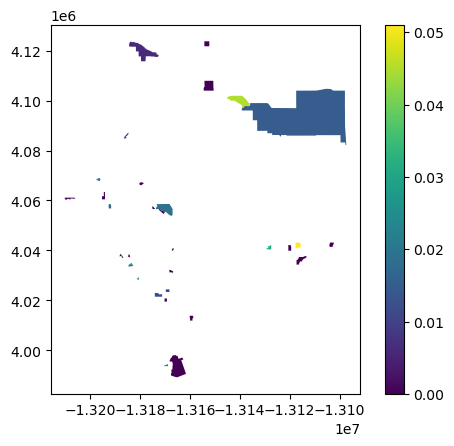

In [32]:
merged.plot(column='f_no_phone',
           legend=True)

Looks like most people have phones, although 5% at the upper end is actually a bit surprising.